# Movie Success Factor Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

## Data Loading

In [2]:
movies_metadata_path = 'movies_metadata.csv'
credits_path = 'credits.csv'
keywords_path = 'keywords.csv'

In [3]:
# Load the CSV files into pandas DataFrames
df_movies = pd.read_csv(movies_metadata_path, low_memory=False)
df_credits = pd.read_csv(credits_path)
df_keywords = pd.read_csv(keywords_path)

In [4]:
print("--- Initial Data Loading Complete ---")
print(f"Movies Metadata shape: {df_movies.shape}")
print(f"Credits shape: {df_credits.shape}")
print(f"Keywords shape: {df_keywords.shape}")

--- Initial Data Loading Complete ---
Movies Metadata shape: (45466, 24)
Credits shape: (45476, 3)
Keywords shape: (46419, 2)


## Data Cleaning and Merging

### Clean df_movies ID

In [19]:
# The 'id' column in movies_metadata is often object type and might contain strings like 'tt0112253'.
# Convert to numeric, setting non-numeric strings to NaN, then drop those rows.
df_movies['id'] = pd.to_numeric(df_movies['id'], errors='coerce')
df_movies = df_movies.dropna(subset=['id']).copy() # Use .copy() to avoid SettingWithCopyWarning
df_movies['id'] = df_movies['id'].astype('int64')# Convert to integer
# Remove duplicate IDs within df_movies, keeping the first occurrence
df_movies = df_movies.drop_duplicates(subset=['id'], keep='first')

### Filter Credits and Keywords based on cleaned Movies IDs

In [20]:
# Get the set of valid integer IDs from the cleaned df_movies
valid_ids = set(df_movies['id'])

# Filter df_credits and df_keywords to only include IDs present in the cleaned df_movies
df_credits_filtered = df_credits[df_credits['id'].isin(valid_ids)].copy()
df_keywords_filtered = df_keywords[df_keywords['id'].isin(valid_ids)].copy()

# Remove duplicate IDs within the *filtered* datasets, keeping the first occurrence
df_credits_filtered = df_credits_filtered.drop_duplicates(subset=['id'], keep='first')
df_keywords_filtered = df_keywords_filtered.drop_duplicates(subset=['id'], keep='first')

### Perform the Merges

In [21]:
# Inner join ensures only movies with metadata, credits, and keywords are included
df_movies_joined = df_movies.merge(df_credits_filtered, on='id', how='inner')
df_movies_joined = df_movies_joined.merge(df_keywords_filtered, on='id', how='inner')

print(f"\n--- After Merging (df_movies_joined) ---")
print(f"Shape: {df_movies_joined.shape}")


--- After Merging (df_movies_joined) ---
Shape: (45432, 27)


## Clean Financial Data (Budget, Revenue) and Filter

In [22]:
# Convert budget to numeric (it's often stored as string)
df_movies_joined['budget'] = pd.to_numeric(df_movies_joined['budget'], errors='coerce')

# Filter out rows where budget or revenue is 0 or NaN
# This significantly reduces the dataset but focuses on financially trackable movies.
df_movies_cleaned = df_movies_joined[
    (df_movies_joined['budget'] != 0) &
    (df_movies_joined['budget'].notna()) & # Explicitly check for NaN
    (df_movies_joined['revenue'] != 0) &
    (df_movies_joined['revenue'].notna()) # Explicitly check for NaN
].copy()

print(f"\n--- After Filtering Budget/Revenue (df_movies_cleaned) ---")
print(f"Shape: {df_movies_cleaned.shape}")
print(f"Number of rows removed due to budget/revenue = 0 or NaN: {df_movies_joined.shape[0] - df_movies_cleaned.shape[0]}")


--- After Filtering Budget/Revenue (df_movies_cleaned) ---
Shape: (5375, 27)
Number of rows removed due to budget/revenue = 0 or NaN: 40057


## Feature Engineering

In [23]:
# Calculate Profit and Return on Investment (ROI)
df_movies_cleaned['profit'] = df_movies_cleaned['revenue'] - df_movies_cleaned['budget']
# Calculate ROI, handle potential division by zero (though budget=0 was filtered out)
df_movies_cleaned['roi'] = np.where(
    df_movies_cleaned['budget'] != 0,
    (df_movies_cleaned['revenue'] - df_movies_cleaned['budget']) / df_movies_cleaned['budget'],
    np.nanargmin # Set to NaN if budget is somehow 0 despite filtering
)
df_movies_cleaned['is_profitable'] = df_movies_cleaned['profit'] > 0

# Convert release_date to datetime
df_movies_cleaned['release_date'] = pd.to_datetime(df_movies_cleaned['release_date'], errors='coerce')

## Parse JSON Columns (Genres)

In [10]:
def extract_genres(genres_str):
    """Extract genre names from the string representation of a list of dictionaries."""
    try:
        genres_list = ast.literal_eval(genres_str)
        return [genre['name'] for genre in genres_list] if isinstance(genres_list, list) else []
    except (ValueError, SyntaxError, KeyError):
        return []

In [11]:
df_movies_cleaned['genres_list'] = df_movies_cleaned['genres'].apply(extract_genres)
df_movies_cleaned['primary_genre'] = df_movies_cleaned['genres_list'].apply(lambda x: x[0] if x else None)

## Basic EDA and Visualization

In [12]:
print(f"\n--- Basic Statistics for Numeric Features ---")
print(df_movies_cleaned[['budget', 'revenue', 'profit', 'roi', 'vote_average', 'vote_count']].describe())


--- Basic Statistics for Numeric Features ---
             budget       revenue        profit  vote_average    vote_count
count  5.375000e+03  5.375000e+03  5.375000e+03   5375.000000   5375.000000
mean   3.110802e+07  9.039182e+07  5.928381e+07      6.273042    733.007628
std    4.018026e+07  1.662182e+08  1.396003e+08      0.928227   1252.041202
min    1.000000e+00  1.000000e+00 -1.657101e+08      0.000000      0.000000
25%    5.053316e+06  7.020199e+06 -1.456000e+06      5.700000     77.000000
50%    1.700000e+07  2.991874e+07  1.110167e+07      6.300000    277.000000
75%    4.000000e+07  1.000000e+08  6.223188e+07      6.900000    801.500000
max    3.800000e+08  2.787965e+09  2.550965e+09      9.100000  14075.000000


In [24]:
# Set seaborn style for better-looking plots
sns.set_theme()

## Plot 1: Budget vs Revenue

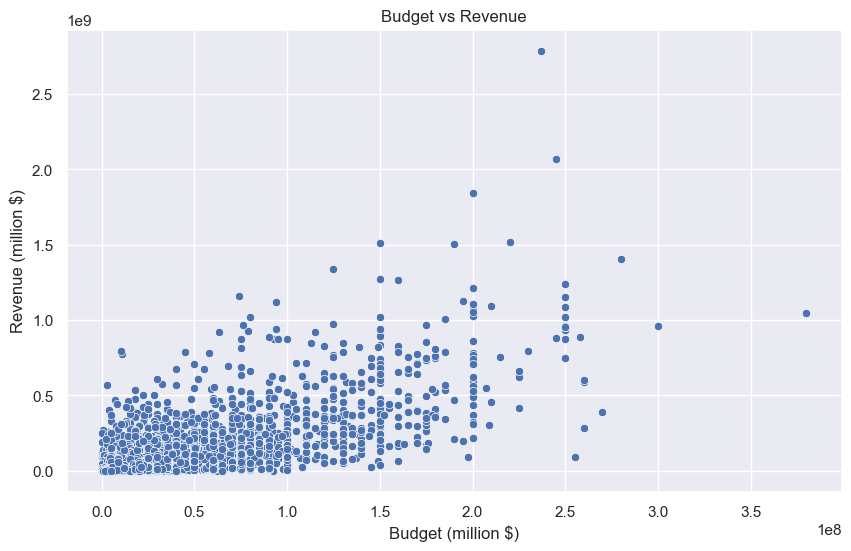

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_movies_cleaned, x='budget', y='revenue')
plt.title('Budget vs Revenue')
plt.xlabel('Budget (million $)')
plt.ylabel('Revenue (million $)')
plt.show()

## Average Revenue by Top Genres

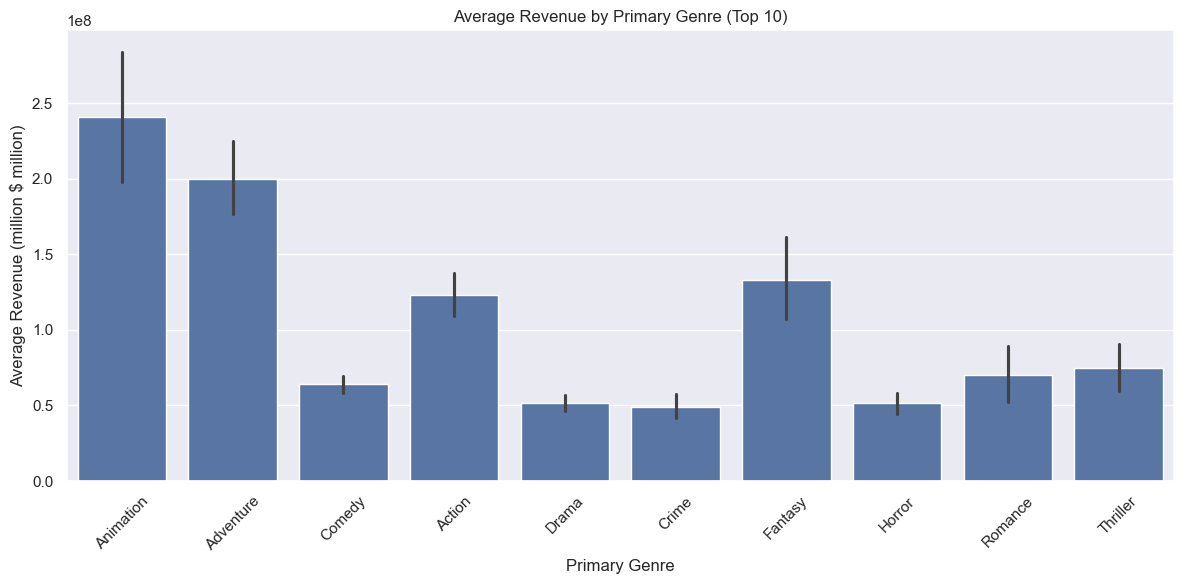

In [15]:
top_genres = df_movies_cleaned['primary_genre'].value_counts().head(10).index
df_top_genres = df_movies_cleaned[df_movies_cleaned['primary_genre'].isin(top_genres)]

plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_genres, x='primary_genre', y='revenue', estimator=np.mean)
plt.title('Average Revenue by Primary Genre (Top 10)')
plt.xlabel('Primary Genre')
plt.ylabel('Average Revenue (million $ million)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Correlation Matrix

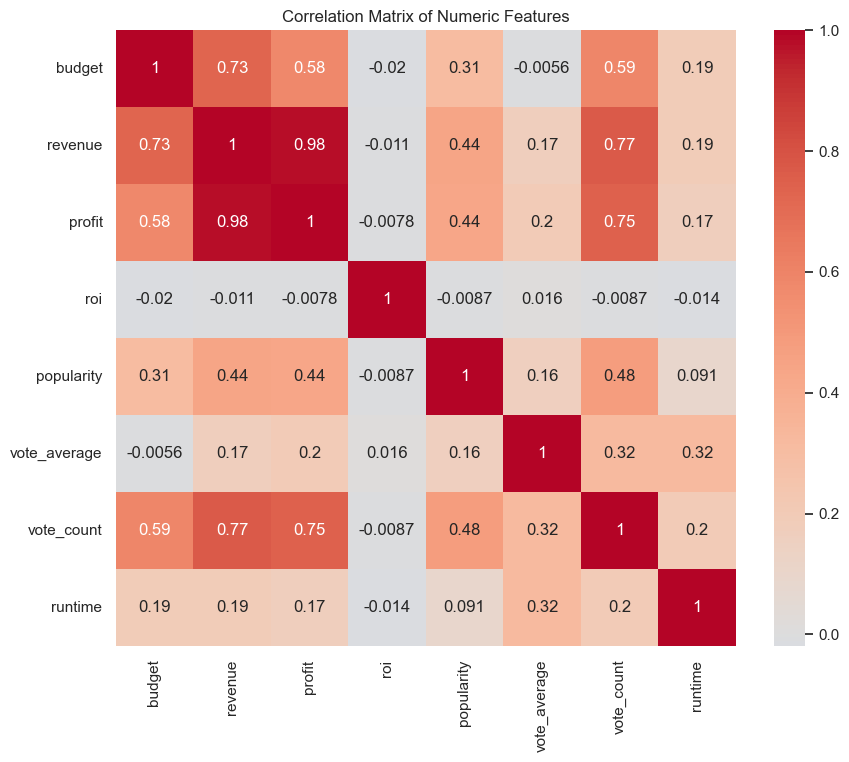

In [16]:
numeric_cols = ['budget', 'revenue', 'profit', 'roi', 'popularity', 'vote_average', 'vote_count', 'runtime']
corr_matrix = df_movies_cleaned[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

## Distribution of ROI (Filtered for realistic values)

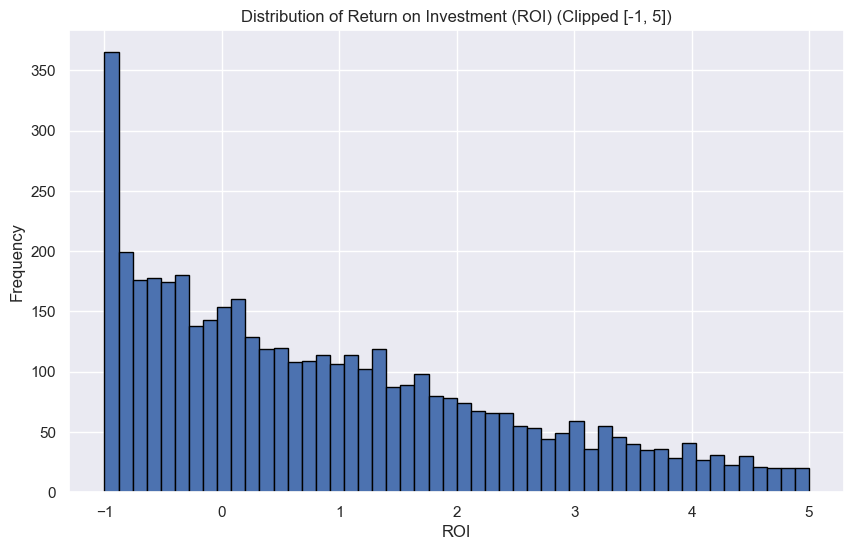

In [25]:
# Filter out extreme ROI values that might skew the histogram
min_roi, max_roi = -1, 5 # Example: Focus on ROI between -100% and 500%
df_roi_filtered = df_movies_cleaned[
    (df_movies_cleaned['roi'] >= min_roi) & (df_movies_cleaned['roi'] <= max_roi)
]

plt.figure(figsize=(10, 6))
plt.hist(df_roi_filtered['roi'], bins=50, edgecolor='black')
plt.title(f'Distribution of Return on Investment (ROI) (Clipped [{min_roi}, {max_roi}])')
plt.xlabel('ROI')
plt.ylabel('Frequency')
plt.show()

# Movie Success Factor Analysis - Summary
## Objective

The goal of this project was to analyze the MovieLens dataset to identify key factors influencing a movie's financial success, primarily focusing on the relationship between budget, revenue, genre, and return on investment (ROI).

## Data

The analysis utilized three main datasets from the MovieLens collection:

- `movies_metadata.csv:` Containing core movie information (budget, revenue, genre, release date, etc.).
- `credits.csv:` Containing cast and crew information.
- `keywords.csv:` Containing plot keywords.

The initial `movies_metadata` dataset contained 45,466 entries. After merging with `credits` and `keywords` (based on matching movie IDs), filtering out entries with zero budget or revenue (which removed ~40,000 rows), and performing standard data cleaning (handling ID types, removing duplicates), the final dataset used for analysis consisted of 5,375 movies.

## Methodology

1. Data Loading & Exploration: Loaded the raw CSV files and performed initial checks on data types, shapes, and content.
2. Data Cleaning & Merging:
    - Corrected the data type of the id column in movies_metadata from object to integer, filtering out non-numeric IDs.
    - Filtered credits and keywords to include only IDs present in the cleaned movies_metadata.
    - Performed inner joins to create a single dataset containing metadata, credits, and keywords for movies where all information was available.
    - Converted the budget column from string to numeric.
    - Filtered the dataset to exclude movies with budget or revenue equal to 0 or NaN.
3. Feature Engineering:
    - Calculated profit = revenue - budget.
    - Calculated ROI = (revenue - budget) / budget.
    - Parsed the JSON-like genres column to extract the primary genre for each movie.
4. Exploratory Data Analysis (EDA):
    - Created visualizations (scatter plots, bar charts, histograms, correlation matrix) using Python libraries (pandas, matplotlib, seaborn).
    - Analyzed the relationships between key variables.

## Key Findings

1. Budget vs. Revenue: There is a strong positive correlation between a movie's budget and its revenue. Generally, higher-budget films tend to generate higher revenues. However, there is significant variance; many high-budget films underperform, and some low-budget films achieve substantial revenue.
1. Genre Performance: Different genres exhibit varying levels of average financial performance.
    - Higher Revenue Genres: Animation and Adventure movies consistently showed the highest average revenue in the dataset.
    - Lower Revenue Genres: Drama, Crime, and Horror genres tended to have lower average revenue.
3. Return on Investment (ROI) Distribution: The distribution of ROI is highly skewed. The most common outcome was a loss (negative ROI), with the peak around -50%. While many films lose money, a smaller number achieve very high returns, creating the long tail in the distribution.
4. Correlation Analysis:
    - `Budget` and `Revenue` showed a strong positive correlation (0.73).
    - `Revenue` and `Profit` showed a very strong positive correlation (0.98).
    - `Budget` and `ROI` showed a very weak correlation (-0.02), indicating that spending more money does not necessarily translate to a higher rate of return.
    - `Popularity` showed a moderate positive correlation with Revenue (0.44).

## Conclusion

Based on the analysis of the cleaned dataset:

- Budget is a significant predictor of revenue, but not a guarantee of profitability or high ROI.
- Genre plays a role in average financial performance, with Animation and Adventure being top performers for average revenue in this sample.
- The film industry is inherently risky, with a large proportion of movies in the dataset showing a financial loss. Success, defined by high ROI, is less common and less predictable by budget alone.

## Limitations

- A substantial portion of the original dataset was removed due to zero or missing budget/revenue values. The analysis focuses on movies where financial data was reported and non-zero, which might bias results towards larger, more mainstream productions.
- The analysis focused on linear relationships and simple comparisons. More complex interactions between factors (e.g., genre and budget, or the impact of release timing) were not explored in depth.
- Factors like cast, director, marketing spend (not available in the dataset), and critical reception were not deeply integrated into the quantitative analysis beyond basic correlations.

This project demonstrated skills in data loading, cleaning, merging disparate data sources, feature engineering, and exploratory data analysis using Python and its data science ecosystem.